In [ ]:

import os
import gc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from pytorch_msssim import ssim
import matplotlib.pyplot as plt

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def set_seed(seed_value=100):
    import random
    import numpy as np
    import torch

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # For multi-GPU
        # For deterministic behavior on CUDNN
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(100) 

In [ ]:
DATA_DIR = r"G:\Camel_Dataset\data"
IMG_SIZE = 256
CHANNELS = 3  # Mgas, Vgas, B
LATENT_DIM = 256  # Reduced from 400 to lower dimensionality (better compression, target reduction)
BATCH_SIZE = 16
NUM_EPOCHS = 200
KL_WARMUP_EPOCHS = 150
BETA=0.1
PATIENCE = 20
EPS = 1e-6  # For log transformation
N_LH_SAMPLES = 1000  # Subsample size for the final LH test
N_CLUSTERS = 5

In [ ]:
file_paths = {
    'mgas_cv': os.path.join(DATA_DIR, 'Maps_Mgas_IllustrisTNG_CV_z=0.00.npy'),
    'vgas_cv': os.path.join(DATA_DIR, 'Maps_Vgas_IllustrisTNG_CV_z=0.00.npy'),
    'b_cv': os.path.join(DATA_DIR, 'Maps_B_IllustrisTNG_CV_z=0.00.npy'),
    'mgas_lh': os.path.join(DATA_DIR, 'Maps_Mgas_IllustrisTNG_LH_z=0.00.npy'),
    'vgas_lh': os.path.join(DATA_DIR, 'Maps_Vgas_IllustrisTNG_LH_z=0.00.npy'),
    'b_lh': os.path.join(DATA_DIR, 'Maps_B_IllustrisTNG_LH_z=0.00.npy'),
}
for p in file_paths.values():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Required file not found: {p}")
print("All required CAMELS map files are present.")

All required CAMELS map files are present.


In [ ]:
def augment_data(data):
    # Performs 90, 180, 270 rotations and horizontal/vertical flips.
    augmented = [data]
    # Rotations (axes=(2,3) for H and W dimensions)
    augmented.append(np.rot90(data, k=1, axes=(2, 3)))
    augmented.append(np.rot90(data, k=2, axes=(2, 3)))
    augmented.append(np.rot90(data, k=3, axes=(2, 3)))
    # Flipping
    augmented.append(np.flip(data, axis=2))  # Horizontal flip
    augmented.append(np.flip(data, axis=3))  # Vertical flip
    return np.concatenate(augmented, axis=0)

In [ ]:
def channel_transform(channel_data, channel_idx, eps=EPS):
    """
    Applies appropriate transformation based on channel content.
    Assumes: 0=Mgas (positive), 1=Vgas (signed), 2=B (positive).
    channel_data: (N, H, W) slice for the channel.
    """
    if channel_idx in (0, 2):  # Mgas, B (Positive density/field) -> log10
        # log10(X + eps) is the standard for density fields
        return np.log10(np.clip(channel_data, 0.0, None) + eps)
    else:  # Vgas (Signed velocity field) -> arcsinh
        # arcsinh preserves the sign and compresses the dynamic range
        return np.arcsinh(channel_data)

def transform_channels(data):
    """
    Applies channel-specific transforms to full dataset (N, C, H, W).
    """
    transformed = np.zeros_like(data)
    for c in range(CHANNELS):
        transformed[:, c] = channel_transform(data[:, c], c)
    return transformed

In [ ]:
#Load, Split CV, Augment, and Apply Transformations
mgas_cv = np.load(file_paths['mgas_cv'])
vgas_cv = np.load(file_paths['vgas_cv'])
b_cv = np.load(file_paths['b_cv'])
cv_raw = np.stack([mgas_cv, vgas_cv, b_cv], axis=1).astype(np.float32)

# Split CV (60/20/20) for Train/Validation/Test
cv_train_raw, cv_tmp_raw = train_test_split(cv_raw, test_size=0.4, random_state=42)
cv_val_raw, cv_test_raw = train_test_split(cv_tmp_raw, test_size=0.5, random_state=42)

# Augment ONLY the raw training data
cv_train_aug_raw = augment_data(cv_train_raw)

In [ ]:
X_train_t = transform_channels(cv_train_aug_raw)
X_val_t = transform_channels(cv_val_raw)
X_test_t = transform_channels(cv_test_raw)

print(f"Train (Augmented) shape after transform: {X_train_t.shape}")
print(f"Validation shape after transform: {X_val_t.shape}")
print(f"Test shape after transform: {X_test_t.shape}")

Train (Augmented) shape after transform: (1458, 3, 256, 256)
Validation shape after transform: (81, 3, 256, 256)
Test shape after transform: (81, 3, 256, 256)


In [ ]:
cv_train_non_aug_t = transform_channels(cv_train_raw)  # Compute non-aug for stats
mean = np.mean(cv_train_non_aug_t, axis=(0, 2, 3))
std = np.std(cv_train_non_aug_t, axis=(0, 2, 3))
std[std == 0] = 1.0  # Protect against division by zero

def normalize(data):
    return (data - mean[None, :, None, None]) / std[None, :, None, None]

# Apply normalization
X_train = normalize(X_train_t)
X_val = normalize(X_val_t)
X_test = normalize(X_test_t)

In [ ]:
# --- 6. Loaders and Cleanup ---
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

train_loader = DataLoader(TensorDataset(X_train), batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(TensorDataset(X_val), batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(TensorDataset(X_test), batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [ ]:
del cv_raw, cv_train_raw, cv_tmp_raw, cv_val_raw, cv_test_raw, cv_train_aug_raw
del X_train_t, X_val_t, X_test_t, cv_train_non_aug_t
gc.collect()

20873

In [ ]:
# --- 7. VAE Model (Adjusted for lower latent dim) ---
class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, img_size=IMG_SIZE, channels=CHANNELS):
        super().__init__()
        self.latent_dim = latent_dim
        feat_h = img_size // (2**5)  # 8
        flatten_size = 512 * feat_h * feat_h

        # Encoder layers
        self.enc1 = nn.Conv2d(channels, 32, 4, 2, 1)  # 3->32, 256->128
        self.enc2 = nn.Conv2d(32, 64, 4, 2, 1)  # 32->64, 128->64
        self.enc3 = nn.Conv2d(64, 128, 4, 2, 1)  # 64->128, 64->32
        self.enc4 = nn.Conv2d(128, 256, 4, 2, 1)  # 128->256, 32->16
        self.enc5 = nn.Conv2d(256, 512, 4, 2, 1)  # 256->512, 16->8
        self.flatten = nn.Flatten()

        self.fc_mu = nn.Linear(flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(flatten_size, latent_dim)

        # Decoder layers
        self.decoder_input = nn.Linear(latent_dim, flatten_size)
        self.up5 = nn.ConvTranspose2d(512, 512, 4, 2, 1)  # 512x8->512x16
        self.conv5 = nn.Conv2d(512 + 256, 256, 3, 1, 1)  # cat 768->256x16
        self.up4 = nn.ConvTranspose2d(256, 256, 4, 2, 1)  # 256x16->256x32
        self.conv4 = nn.Conv2d(256 + 128, 128, 3, 1, 1)  # cat 384->128x32
        self.up3 = nn.ConvTranspose2d(128, 128, 4, 2, 1)  # 128x32->128x64
        self.conv3 = nn.Conv2d(128 + 64, 64, 3, 1, 1)  # cat 192->64x64
        self.up2 = nn.ConvTranspose2d(64, 64, 4, 2, 1)  # 64x64->64x128
        self.conv2 = nn.Conv2d(64 + 32, 32, 3, 1, 1)  # cat 96->32x128
        self.up1 = nn.ConvTranspose2d(32, 32, 4, 2, 1)  # 32x128->32x256
        self.conv1 = nn.Conv2d(32, channels, 3, 1, 1)  # cat 35->3x256

    def encode(self, x):
        h1 = F.leaky_relu(self.enc1(x), 0.01)  # 32x128x128
        h2 = F.leaky_relu(self.enc2(h1), 0.01)  # 64x64x64
        h3 = F.leaky_relu(self.enc3(h2), 0.01)  # 128x32x32
        h4 = F.leaky_relu(self.enc4(h3), 0.01)  # 256x16x16
        h5 = F.leaky_relu(self.enc5(h4), 0.01)  # 512x8x8
        h5_flat = self.flatten(h5)
        mu = self.fc_mu(h5_flat)
        logvar = self.fc_logvar(h5_flat)
        skips = [h1, h2, h3, h4]  # Skips for decoder
        return mu, logvar, skips

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skips):
        # x is the original input, passed from forward
        h = self.decoder_input(z)
        h = h.view(h.size(0), 512, 8, 8)
        # Up to 16x16
        h = F.leaky_relu(self.up5(h), 0.01)  # 512x16x16
        h = torch.cat([h, skips[3]], dim=1)  # cat h4 (256x16)
        h = F.leaky_relu(self.conv5(h), 0.01)  # 256x16x16
        # Up to 32x32
        h = F.leaky_relu(self.up4(h), 0.01)  # 256x32x32
        h = torch.cat([h, skips[2]], dim=1)  # cat h3 (128x32)
        h = F.leaky_relu(self.conv4(h), 0.01)  # 128x32x32
        # Up to 64x64
        h = F.leaky_relu(self.up3(h), 0.01)  # 128x64x64
        h = torch.cat([h, skips[1]], dim=1)  # cat h2 (64x64)
        h = F.leaky_relu(self.conv3(h), 0.01)  # 64x64x64
        # Up to 128x128
        h = F.leaky_relu(self.up2(h), 0.01)  # 64x128x128
        h = torch.cat([h, skips[0]], dim=1)  # cat h1 (32x128)
        h = F.leaky_relu(self.conv2(h), 0.01)  # 32x128x128
        # Up to 256x256
        h = F.leaky_relu(self.up1(h), 0.01)  # 32x256x256

        h = self.conv1(h)  # 3x256x256, linear output
        return h

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, skips)
        return recon, mu, logvar

In [ ]:
def vae_loss(recon, x, mu, logvar, epoch, kl_warmup_epochs=KL_WARMUP_EPOCHS, beta=BETA, latent_dim=LATENT_DIM):
    """
    Computes VAE loss: Recon Loss + β-weighted KL Divergence.
    Includes Linear KL_w Ramp-up and the Free Bits penalty to prevent Posterior Collapse.
    """
    FREE_BITS = 1.0

    # Reconstruction Loss: Weighted MSE + (1 - SSIM)
    mse = F.mse_loss(recon, x, reduction='mean')
    ssim_val = ssim(recon, x, data_range=1.0, size_average=True)
    recon_loss = 0.8 * mse + 0.2 * (1 - ssim_val)

    # KL Divergence (Unweighted)
    # KL per dimension: -0.5 * (1 + logvar - mu^2 - exp(logvar))
    kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())

    # Applied Free Bits per-dimension before the mean
    # The max(kl_per_dim, 0) is already done by clipping the overall loss later

    # Masking: Mean only over the active latent dimensions (10:)
    if latent_dim > 10:
        kl_loss_unweighted = torch.mean(kl_per_dim[:, 10:])
    else:
        kl_loss_unweighted = torch.mean(kl_per_dim)

    # CRITICAL FIX: Apply Free Bits Penalty (P2)
    # This ensures the KL loss is at least FREE_BITS before the model is penalized.
    kl_loss_with_penalty = torch.max(kl_loss_unweighted, torch.tensor(FREE_BITS, device=kl_loss_unweighted.device)) - FREE_BITS

    # KL Annealing/Warmup Weight
    epoch_tensor = torch.tensor(epoch, dtype=torch.float32)

    if epoch <= kl_warmup_epochs:
        # Linear ramp-up: KL_w goes from 0 to beta over kl_warmup_epochs
        kl_weight = beta * (epoch_tensor / kl_warmup_epochs)
    else:
        # Cyclical annealing after the linear warmup period
        kl_weight = beta * (torch.sin(2 * torch.pi * epoch_tensor / kl_warmup_epochs) + 1) / 2

    # Total Loss
    # We use kl_loss_with_penalty here
    total_loss = recon_loss + kl_weight * kl_loss_with_penalty

    # Detach and return the unweighted KL loss for monitoring purposes only
    return total_loss, recon_loss.detach(), kl_loss_unweighted.detach(), kl_weight

In [ ]:
def compute_per_channel_mse(recon, x):
    mse_per_channel = torch.mean((recon - x) ** 2, dim=(0, 2, 3))  # Mean over batch, H, W per channel
    return mse_per_channel.detach().cpu().numpy()

In [ ]:
# Training Loop 
from torch.optim.lr_scheduler import CosineAnnealingLR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)  # Cosine annealing scheduler

best_val_loss = float('inf')
patience_counter = 0
SAVE_PATH = "best_vae_model.pt"

print(f"Starting training on {device}...")

for epoch in range(1, NUM_EPOCHS + 1):
    # Training phase
    model.train()
    train_tot_loss = 0.0
    train_channel_mses = np.zeros(CHANNELS)  # Accumulate per-channel MSE
    n_train_samples = 0
    for (batch,) in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss, _, _, _ = vae_loss(recon, batch, mu, logvar, epoch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        train_tot_loss += loss.item() * batch.size(0)

        # Per-channel monitoring (sampling every 10 batches to save compute)
        if epoch % 10 == 0:
            ch_mse = compute_per_channel_mse(recon, batch)
            train_channel_mses += ch_mse * batch.size(0)
            n_train_samples += batch.size(0)

    avg_train_loss = train_tot_loss / len(train_loader.dataset)
    if n_train_samples > 0:
        avg_train_channel_mses = train_channel_mses / n_train_samples

    # Validation phase
    model.eval()
    val_tot_loss = 0.0
    val_rloss, val_kloss = 0.0, 0.0
    val_channel_mses = np.zeros(CHANNELS)
    n_val_samples = 0
    with torch.no_grad():
        for (batch,) in val_loader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            loss, rloss, kloss, kl_w = vae_loss(recon, batch, mu, logvar, epoch)
            val_tot_loss += loss.item() * batch.size(0)
            val_rloss += rloss.item() * batch.size(0)
            val_kloss += kloss.item() * batch.size(0)

            ch_mse = compute_per_channel_mse(recon, batch)
            val_channel_mses += ch_mse * batch.size(0)
            n_val_samples += batch.size(0)

    avg_val_loss = val_tot_loss / len(val_loader.dataset)
    avg_val_rloss = val_rloss / len(val_loader.dataset)
    avg_val_kloss = val_kloss / len(val_loader.dataset)
    if n_val_samples > 0:
        avg_val_channel_mses = val_channel_mses / n_val_samples

    scheduler.step()  # Update LR with scheduler

    # Print with per-channel info (every 10 epochs)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f} (Recon: {avg_val_rloss:.5f}, KL: {avg_val_kloss:.5f}, KL_w: {kl_w:.3f})")
        print(f"  Val Per-Channel MSE: Ch0(Mgas): {avg_val_channel_mses[0]:.4f}, Ch1(Vgas): {avg_val_channel_mses[1]:.4f}, Ch2(B): {avg_val_channel_mses[2]:.4f}")
    else:
        print(f"Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f} (Recon: {avg_val_rloss:.5f}, KL: {avg_val_kloss:.5f}, KL_w: {kl_w:.3f})")

    # Early Stopping check
    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), SAVE_PATH)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

# Load best model
model.load_state_dict(torch.load(SAVE_PATH))

Starting training on cuda...
Epoch 1/200 | Train Loss: 0.53406 | Val Loss: 0.35188 (Recon: 0.35188, KL: 0.05611, KL_w: 0.001)
Epoch 2/200 | Train Loss: 0.31945 | Val Loss: 0.28131 (Recon: 0.28131, KL: 0.31149, KL_w: 0.001)
Epoch 3/200 | Train Loss: 0.25107 | Val Loss: 0.21873 (Recon: 0.21873, KL: 0.37233, KL_w: 0.002)
Epoch 4/200 | Train Loss: 0.18443 | Val Loss: 0.15365 (Recon: 0.15365, KL: 0.70644, KL_w: 0.003)
Epoch 5/200 | Train Loss: 0.12483 | Val Loss: 0.10157 (Recon: 0.10157, KL: 0.72930, KL_w: 0.003)
Epoch 6/200 | Train Loss: 0.08771 | Val Loss: 0.07048 (Recon: 0.07048, KL: 0.66742, KL_w: 0.004)
Epoch 7/200 | Train Loss: 0.06369 | Val Loss: 0.05442 (Recon: 0.05442, KL: 0.15002, KL_w: 0.005)
Epoch 8/200 | Train Loss: 3.90728 | Val Loss: 0.04133 (Recon: 0.04133, KL: 0.23879, KL_w: 0.005)
Epoch 9/200 | Train Loss: 0.03888 | Val Loss: 0.03487 (Recon: 0.03487, KL: 0.30281, KL_w: 0.006)
Epoch 10/200 | Train Loss: 0.03389 | Val Loss: 0.03065 (Recon: 0.03065, KL: 0.32611, KL_w: 0.007)


<All keys matched successfully>

In [ ]:
# Baseline Losses (MSE) 
def compute_baseline_loss(loader, device, loss_type="mse"):
    total_loss = 0.0
    n_samples = 0
    mean_loss_val = 0.0  # For mean baseline

    for (batch,) in loader:
        batch = batch.to(device)

        # Zero baseline (predict all zeros)
        zero_pred = torch.zeros_like(batch)

        # Mean baseline (predict mean value of batch)
        mean_pred = batch.mean().expand_as(batch)

        if loss_type == "mse":
            zero_loss = F.mse_loss(zero_pred, batch, reduction="sum")
            mean_loss = F.mse_loss(mean_pred, batch, reduction="sum")
        else:
            zero_loss = F.l1_loss(zero_pred, batch, reduction="sum")
            mean_loss = F.l1_loss(mean_pred, batch, reduction="sum")

        total_loss += zero_loss.item()
        mean_loss_val = mean_loss.item()  # Last batch for print
        n_samples += batch.size(0) * batch[0].numel()

    avg_zero_loss = total_loss / n_samples

    print(f"Baseline Zero-{loss_type.upper()} Loss: {avg_zero_loss:.5f}")
    print(f"Baseline Mean-{loss_type.upper()} Loss: {mean_loss_val / n_samples:.5f}")

compute_baseline_loss(test_loader, device, loss_type="mse")

Baseline Zero-MSE Loss: 0.99740
Baseline Mean-MSE Loss: 0.01338


In [ ]:
# Final Evaluation on LH Test Set 
mgas_lh = np.load(file_paths['mgas_lh'], mmap_mode='r')
vgas_lh = np.load(file_paths['vgas_lh'], mmap_mode='r')
b_lh = np.load(file_paths['b_lh'], mmap_mode='r')

# Subsample 
n_total_lh = mgas_lh.shape[0]
lh_indices = np.random.choice(n_total_lh, size=N_LH_SAMPLES, replace=False)

# Load only the subsampled slices into memory
lh_sub_raw = np.stack([
    np.array(mgas_lh[lh_indices]),
    np.array(vgas_lh[lh_indices]),
    np.array(b_lh[lh_indices])
], axis=1).astype(np.float32)

# Apply same transformations and normalization (FIXED: per-channel)
lh_sub_t = transform_channels(lh_sub_raw)
lh_sub_n = normalize(lh_sub_t)
lh_test = torch.from_numpy(lh_sub_n).float()
lh_loader = DataLoader(TensorDataset(lh_test), batch_size=BATCH_SIZE, shuffle=False)

print(f"\nEvaluating final model on {N_LH_SAMPLES} external LH test samples...")

model.eval()
lh_errors = []
lh_latents = []
with torch.no_grad():
    for (batch,) in lh_loader:
        batch = batch.to(device)
        recon, mu, _ = model(batch)
        # MSE for eval
        mse_per_sample = F.mse_loss(recon, batch, reduction='none').mean(dim=(1, 2, 3)).cpu().numpy()
        lh_errors.append(mse_per_sample)
        lh_latents.append(mu.cpu().numpy())

lh_errors = np.concatenate(lh_errors)
lh_latents = np.concatenate(lh_latents)

print(f"Final LH Mean Reconstruction Error (MSE): {lh_errors.mean():.6f}")
print(f"Shape of Extracted Latent Vectors: {lh_latents.shape}")

# Cleanup
del mgas_lh, vgas_lh, b_lh, lh_sub_raw, lh_sub_t, lh_sub_n, lh_test
gc.collect()


Evaluating final model on 1000 external LH test samples...
Final LH Mean Reconstruction Error (MSE): 0.001441
Shape of Extracted Latent Vectors: (1000, 256)


88774

In [ ]:
# Comprehensive Metrics Evaluation (Implemented/Added missing ones)
# Collect latents, mus, logvars from test set (for metrics)
test_latents, test_mus, test_logvars = [], [], []
test_recons = [] 

model.eval()
with torch.no_grad():
    for (batch,) in test_loader:
        batch = batch.to(device)
        recon, mu, logvar = model(batch)
        z = mu  # Used mu as latent rep
        test_latents.append(z.cpu())
        test_mus.append(mu.cpu())
        test_logvars.append(logvar.cpu())
        test_recons.append(recon.cpu())

test_latents = torch.cat(test_latents).numpy()
test_mus = torch.cat(test_mus)
test_logvars = torch.cat(test_logvars)
test_data = torch.cat([b[0] for b in test_loader.dataset])  # Original test data
test_recons = torch.cat(test_recons)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness
from sklearn.neighbors import NearestNeighbors
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sklearn.manifold import TSNE


#  PERFORMANCE EVALUATION


def evaluate_latent_performance(model, X_test, X_test_recon_pca_img, latent_dim=256, device=None, n_samples=3):

    model.eval()
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_test = X_test.to(device)

    # ------------- VAE Reconstruction -------------
    with torch.no_grad():
        vae_recon, mu, logvar = model(X_test)
    vae_recon = vae_recon.cpu()
    X_test_np = X_test.cpu().numpy()
    vae_recon_np = vae_recon.numpy()
    pca_recon_np = X_test_recon_pca_img.cpu().numpy() if torch.is_tensor(X_test_recon_pca_img) else X_test_recon_pca_img

    # =========================================================
    #                  RECONSTRUCTION METRICS
    # =========================================================
    def mse_score(x, xhat): return np.mean((x - xhat) ** 2)
    def psnr_score(x, xhat, data_range=1.0):
        mse = np.mean((x - xhat) ** 2)
        return 20 * np.log10(data_range) - 10 * np.log10(mse + 1e-12)
    def ssim_score(x, xhat):
        ssim_vals = []
        for i in range(x.shape[0]):
            vals = [ssim(x[i, c], xhat[i, c], data_range=1.0) for c in range(x.shape[1])]
            ssim_vals.append(np.mean(vals))
        return np.mean(ssim_vals)

    mse_val = mse_score(X_test_np, vae_recon_np)
    psnr_val = psnr_score(X_test_np, vae_recon_np)
    ssim_val = ssim_score(X_test_np, vae_recon_np)

    print("======== Reconstruction Quality ========")
    print(f"MSE  : {mse_val:.6f}")
    print(f"PSNR : {psnr_val:.2f} dB")
    print(f"SSIM : {ssim_val:.4f}")

    # =========================================================
    #               GEOMETRY PRESERVATION METRICS
    # =========================================================
    X_flat = X_test_np.reshape(len(X_test_np), -1)
    Z = mu.cpu().numpy()

    # --- Trustworthiness ---
    tw = trustworthiness(X_flat, Z, n_neighbors=10)
    # --- kNN Overlap ---
    nnX = NearestNeighbors(n_neighbors=11).fit(X_flat).kneighbors(return_distance=False)[:,1:]
    nnZ = NearestNeighbors(n_neighbors=11).fit(Z).kneighbors(return_distance=False)[:,1:]
    overlaps = [len(set(a).intersection(set(b)))/10 for a,b in zip(nnX, nnZ)]
    knn_overlap_val = float(np.mean(overlaps))

    print("\n======== Geometry Preservation ========")
    print(f"Trustworthiness@10 : {tw:.4f}")
    print(f"kNN Overlap@10     : {knn_overlap_val:.4f}")

    # =========================================================
    #               COMPRESSION SUMMARY
    # =========================================================
    original_dim = np.prod(X_test_np.shape[1:])  # C*H*W
    ratio = original_dim / latent_dim
    print("\n======== Compression ========")
    print(f"Dimensionality Reduction: {original_dim} → {latent_dim}  (≈ {ratio:.1f}× smaller)")

    # =========================================================
    #                     RETURN METRICS
    # =========================================================
    return {
        "Reconstruction": {"MSE": mse_val, "PSNR": psnr_val, "SSIM": ssim_val},
        "Geometry": {"Trustworthiness": tw, "kNN_Overlap": knn_overlap_val},
        "Compression": {"OriginalDim": original_dim, "LatentDim": latent_dim, "Ratio": ratio}
    }
# After training
model.load_state_dict(torch.load("best_vae_model.pt"))
model.eval()

# Run evaluation
results = evaluate_latent_performance(
    model,
    X_test=X_test,
    X_test_recon_pca_img=X_test_recon_pca_img,
    latent_dim=256,
    device=torch.device('cuda')
)

print("\nFinal Summary:\n", results)


======== Reconstruction Quality ========
MSE  : 0.001453
PSNR : 28.38 dB
SSIM : 0.9875

======== Geometry Preservation ========
Trustworthiness@10 : 0.7900
kNN Overlap@10     : 0.3086

======== Compression ========
Dimensionality Reduction: 196608 → 256  (≈ 768.0× smaller)

Final Summary:
 {'Reconstruction': {'MSE': np.float32(0.0014530536), 'PSNR': np.float64(28.377185821533203), 'SSIM': np.float64(0.9875450561283093)}, 'Geometry': {'Trustworthiness': np.float64(0.7899538215059844), 'kNN_Overlap': 0.30864197530864196}, 'Compression': {'OriginalDim': np.int64(196608), 'LatentDim': 256, 'Ratio': np.float64(768.0)}}



--- PCA Results ---
Explained Variance Ratio (Cumulative): 0.6480
Shape of PCA Components: (81, 256)
Test Reconstruction MSE (flattened): 0.495323
Test Mean Reconstruction Error (MSE per image): 0.495323
LH Mean Reconstruction Error (MSE): 0.492135
Shape of PCA Components (LH): (1000, 256)


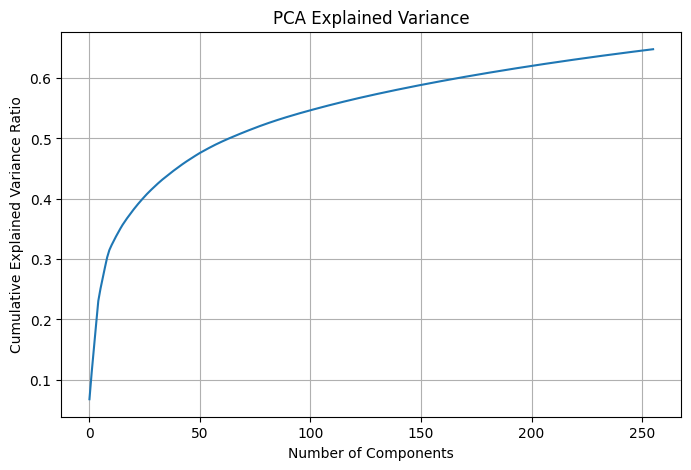

27802

In [ ]:
# --- PCA Implementation (Added as Baseline/Comparison to VAE) ---
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Already normalized, but for completeness

# Flatten normalized data for PCA (N, C*H*W) -> (N, 196608)
def flatten_data(data_tensor):
    return data_tensor.view(data_tensor.size(0), -1).numpy()

# Flatten train/val/test
X_train_flat = flatten_data(X_train)
X_val_flat = flatten_data(X_val)
X_test_flat = flatten_data(X_test)

# Fit PCA on train (n_components=256 to match VAE latent_dim)
n_pca_components = LATENT_DIM  # 256
pca = PCA(n_components=n_pca_components, random_state=42)
pca.fit(X_train_flat)

# Transform sets
X_train_pca = pca.transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)
X_test_pca = pca.transform(X_test_flat)

# Reconstruction via inverse_transform
X_train_recon_pca = pca.inverse_transform(X_train_pca)
X_val_recon_pca = pca.inverse_transform(X_val_pca)
X_test_recon_pca = pca.inverse_transform(X_test_pca)

# Reshape back to image shape for metrics (N, C, H, W)
X_train_recon_pca_img = X_train_recon_pca.reshape(X_train.shape)
X_val_recon_pca_img = X_val_recon_pca.reshape(X_val.shape)
X_test_recon_pca_img = X_test_recon_pca.reshape(X_test.shape)

# Convert X_test to numpy for consistency
X_test_np = X_test.numpy()

# PCA Metrics
print("\n--- PCA Results ---")
print(f"Explained Variance Ratio (Cumulative): {pca.explained_variance_ratio_.sum():.4f}")
print(f"Shape of PCA Components: {X_test_pca.shape}")

# Reconstruction MSE on test (mean per sample, averaged over dims)
test_mse_pca = np.mean((X_test_flat - X_test_recon_pca)**2, axis=1).mean()
print(f"Test Reconstruction MSE (flattened): {test_mse_pca:.6f}")

# Per-image MSE (like VAE LH eval) 
test_mse_per_sample_pca = np.mean((X_test_recon_pca_img - X_test_np)**2, axis=(1,2,3)).mean()
print(f"Test Mean Reconstruction Error (MSE per image): {test_mse_per_sample_pca:.6f}")

# For LH: Transform and recon
# (Reuse lh_sub_n from earlier, or reload if needed)
mgas_lh = np.load(file_paths['mgas_lh'], mmap_mode='r')
vgas_lh = np.load(file_paths['vgas_lh'], mmap_mode='r')
b_lh = np.load(file_paths['b_lh'], mmap_mode='r')

# Subsample by indices from mmap objects
n_total_lh = mgas_lh.shape[0]
lh_indices = np.random.choice(n_total_lh, size=N_LH_SAMPLES, replace=False)

# Load only the subsampled slices into memory
lh_sub_raw = np.stack([
    np.array(mgas_lh[lh_indices]),
    np.array(vgas_lh[lh_indices]),
    np.array(b_lh[lh_indices])
], axis=1).astype(np.float32)

# Apply same transformations and normalization (FIXED: per-channel)
lh_sub_t = transform_channels(lh_sub_raw)
lh_sub_n = normalize(lh_sub_t)
lh_test = torch.from_numpy(lh_sub_n).float()
lh_loader = DataLoader(TensorDataset(lh_test), batch_size=BATCH_SIZE, shuffle=False)

lh_sub_flat = flatten_data(lh_test)
lh_pca = pca.transform(lh_sub_flat)
lh_recon_pca = pca.inverse_transform(lh_pca)
lh_recon_pca_img = lh_recon_pca.reshape(lh_test.shape)
lh_test_np = lh_test.numpy()
lh_errors_pca = np.mean((lh_recon_pca_img - lh_test_np)**2, axis=(1,2,3))
print(f"LH Mean Reconstruction Error (MSE): {lh_errors_pca.mean():.6f}")
print(f"Shape of PCA Components (LH): {lh_pca.shape}")

# Optional: Compare to VAE (e.g., plot cumulative explained var)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Cleanup PCA data
del X_train_flat, X_val_flat, X_test_flat, X_train_pca, X_val_pca, X_test_pca
del X_train_recon_pca, X_val_recon_pca, X_test_recon_pca, X_train_recon_pca_img
del X_val_recon_pca_img, X_test_recon_pca_img
gc.collect()


--- Running PCA Baseline Reconstruction ---
Cumulative Explained Variance: 0.6480

======== Visual Comparisons ========


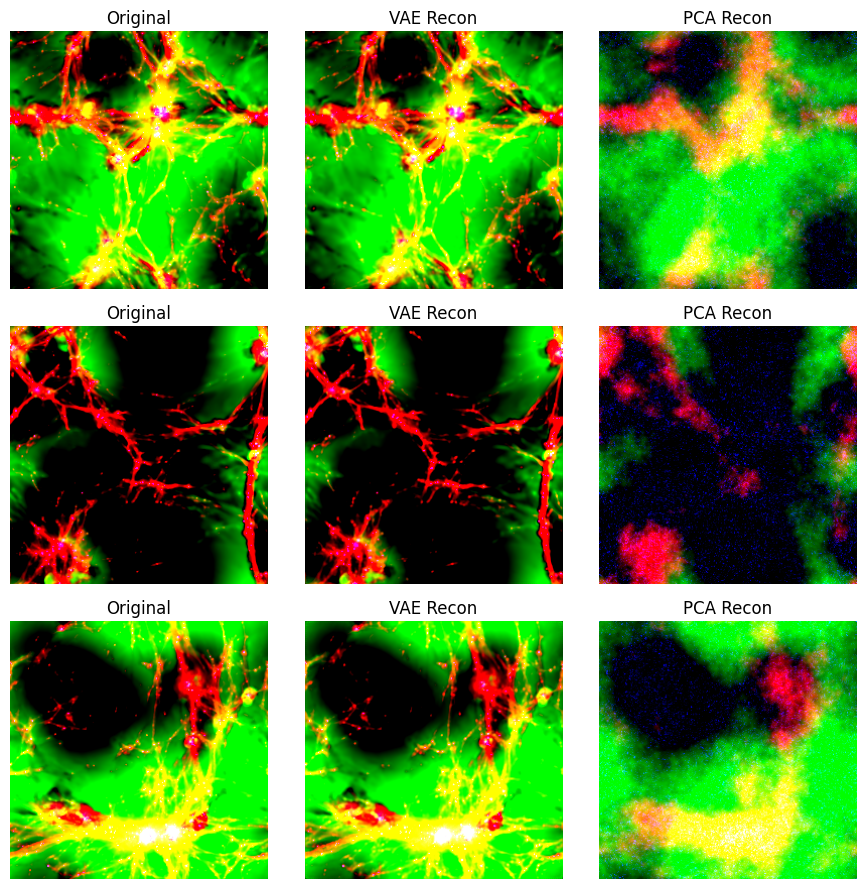

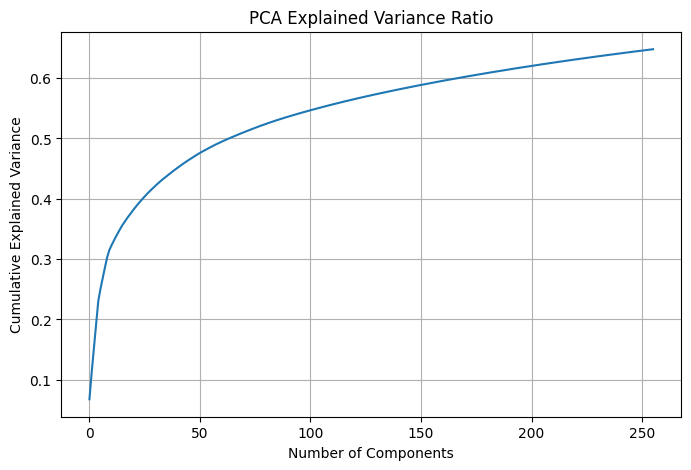


======== Quantitative Summary ========
Compression: 196608 → 256 (768.0× smaller)

Metric                  VAE         PCA
----------------------------------------
MSE                0.001453    0.495323
PSNR              28.377865    3.051118
SSIM               0.987545    0.125638
----------------------------------------
Trustworthiness@10 : 0.7900
kNN Overlap@10     : 0.3086
Cumulative PCA Variance : 0.6480

Final Summary:
 {'VAE': {'MSE': np.float32(0.001452826), 'PSNR': np.float64(28.377864837646484), 'SSIM': np.float64(0.9875446698327803)}, 'PCA': {'MSE': np.float32(0.4953227), 'PSNR': np.float64(3.0511176586151123), 'SSIM': np.float64(0.12563772530735864)}, 'Geometry': {'Trustworthiness': np.float64(0.7899538215059844), 'kNN_Overlap': 0.30864197530864196}, 'Compression': {'OriginalDim': np.int64(196608), 'LatentDim': 256, 'Ratio': np.float64(768.0)}, 'PCA_Explained_Var': np.float32(0.6480315)}


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness
from sklearn.neighbors import NearestNeighbors
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
import gc

# =========================================================
#         COMBINED PERFORMANCE & BENCHMARK EVALUATION
# =========================================================
def evaluate_latent_performance_with_pca(model, X_train, X_val, X_test,
                                         latent_dim=256, device=None, n_samples=3):

    model.eval()
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_test = X_test.to(device)

    # ----------------- VAE Reconstruction -----------------
    with torch.no_grad():
        vae_recon, mu, logvar = model(X_test)
    vae_recon_np = vae_recon.cpu().numpy()
    X_test_np = X_test.cpu().numpy()
    Z = mu.cpu().numpy()

    # =========================================================
    #                  RECONSTRUCTION METRICS
    # =========================================================
    def mse_score(x, xhat): return np.mean((x - xhat) ** 2)
    def psnr_score(x, xhat, data_range=1.0):
        mse = np.mean((x - xhat) ** 2)
        return 20 * np.log10(data_range) - 10 * np.log10(mse + 1e-12)
    def ssim_score(x, xhat):
        vals = []
        for i in range(x.shape[0]):
            c_vals = [ssim(x[i, c], xhat[i, c], data_range=1.0) for c in range(x.shape[1])]
            vals.append(np.mean(c_vals))
        return np.mean(vals)

    def recon_metrics(x, xhat):
        return {
            "MSE": mse_score(x, xhat),
            "PSNR": psnr_score(x, xhat),
            "SSIM": ssim_score(x, xhat)
        }

    # ----------------- VAE Metrics -----------------
    vae_metrics = recon_metrics(X_test_np, vae_recon_np)

    # =========================================================
    #                     PCA BASELINE
    # =========================================================
    def flatten_data(data_tensor):
        return data_tensor.view(data_tensor.size(0), -1).cpu().numpy()

    X_train_flat = flatten_data(X_train)
    X_val_flat = flatten_data(X_val)
    X_test_flat = flatten_data(X_test.cpu())

    print("\n--- Running PCA Baseline Reconstruction ---")
    pca = PCA(n_components=latent_dim, random_state=42)
    pca.fit(X_train_flat)
    X_test_pca = pca.transform(X_test_flat)
    X_test_recon_pca = pca.inverse_transform(X_test_pca)
    X_test_recon_pca_img = X_test_recon_pca.reshape(X_test_np.shape)
    pca_metrics = recon_metrics(X_test_np, X_test_recon_pca_img)

    print(f"Cumulative Explained Variance: {pca.explained_variance_ratio_.sum():.4f}")

    # =========================================================
    #               GEOMETRY PRESERVATION (VAE only)
    # =========================================================
    X_flat = X_test_np.reshape(len(X_test_np), -1)
    tw = trustworthiness(X_flat, Z, n_neighbors=10)
    nnX = NearestNeighbors(n_neighbors=11).fit(X_flat).kneighbors(return_distance=False)[:, 1:]
    nnZ = NearestNeighbors(n_neighbors=11).fit(Z).kneighbors(return_distance=False)[:, 1:]
    overlaps = [len(set(a).intersection(set(b))) / 10 for a, b in zip(nnX, nnZ)]
    knn_overlap_val = float(np.mean(overlaps))

    # =========================================================
    #                COMPRESSION SUMMARY
    # =========================================================
    original_dim = np.prod(X_test_np.shape[1:])
    ratio = original_dim / latent_dim

    # =========================================================
    #                  VISUALIZATION SECTION
    # =========================================================
    def visualize_reconstruction(X_true, X_vae, X_pca, n_samples=3):
        fig, axes = plt.subplots(n_samples, 3, figsize=(9, 3 * n_samples))
        for i in range(n_samples):
            for j, (img, title) in enumerate(zip(
                [X_true[i], X_vae[i], X_pca[i]],
                ["Original", "VAE Recon", "PCA Recon"]
            )):
                ax = axes[i, j] if n_samples > 1 else axes[j]
                ax.imshow(np.clip(np.transpose(img, (1, 2, 0)), 0, 1))
                ax.set_title(title)
                ax.axis("off")
        plt.tight_layout()
        plt.show()

    def visualize_pca_variance(pca):
        plt.figure(figsize=(8, 5))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("PCA Explained Variance Ratio")
        plt.grid(True)
        plt.show()

    print("\n======== Visual Comparisons ========")
    visualize_reconstruction(X_test_np, vae_recon_np, X_test_recon_pca_img, n_samples=n_samples)
    visualize_pca_variance(pca)

    # =========================================================
    #                     PRINT SUMMARY
    # =========================================================
    print("\n======== Quantitative Summary ========")
    print(f"Compression: {original_dim} → {latent_dim} ({ratio:.1f}× smaller)\n")
    print(f"{'Metric':<15}{'VAE':>12}{'PCA':>12}")
    print("-" * 40)
    for k in vae_metrics.keys():
        print(f"{k:<15}{vae_metrics[k]:>12.6f}{pca_metrics[k]:>12.6f}")
    print("-" * 40)
    print(f"Trustworthiness@10 : {tw:.4f}")
    print(f"kNN Overlap@10     : {knn_overlap_val:.4f}")
    print(f"Cumulative PCA Variance : {pca.explained_variance_ratio_.sum():.4f}")

    # Clean up PCA intermediates to save memory
    del X_train_flat, X_val_flat, X_test_flat, X_test_pca, X_test_recon_pca, X_test_recon_pca_img
    gc.collect()

    # =========================================================
    #                     RETURN RESULTS
    # =========================================================
    return {
        "VAE": vae_metrics,
        "PCA": pca_metrics,
        "Geometry": {"Trustworthiness": tw, "kNN_Overlap": knn_overlap_val},
        "Compression": {"OriginalDim": original_dim, "LatentDim": latent_dim, "Ratio": ratio},
        "PCA_Explained_Var": pca.explained_variance_ratio_.sum()
    }
results = evaluate_latent_performance_with_pca(
    model,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    latent_dim=256,
    device=torch.device('cuda')
)

print("\nFinal Summary:\n", results)


In [ ]:
# PCA Implementation 
from sklearn.decomposition import PCA
import numpy as np
import torch
import matplotlib.pyplot as plt

X_test_flat = X_test.view(X_test.size(0), -1).numpy()
pca_test_latents = pca.transform(X_test_flat)
pca_test_recon_flat = pca.inverse_transform(pca_test_latents)
pca_test_recon_img = pca_test_recon_flat.reshape(X_test.shape)

# Generate VAE reconstructions and latents for comparison
with torch.no_grad():
    vae_recon_test, vae_mu_test, _ = model(X_test.to(device))
    vae_test_latents = vae_mu_test.cpu().numpy() 
    vae_recon_test_img = vae_recon_test.cpu()

X_test_np = X_test.numpy()

print("PCA and VAE data prepared for comparison.")


PCA and VAE data prepared for comparison.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8606732..45.26983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.726596..3.2246122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7635949..45.2819].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.8603673..47.228905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6104872..3.2939765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.852902..52.165222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6706398..42

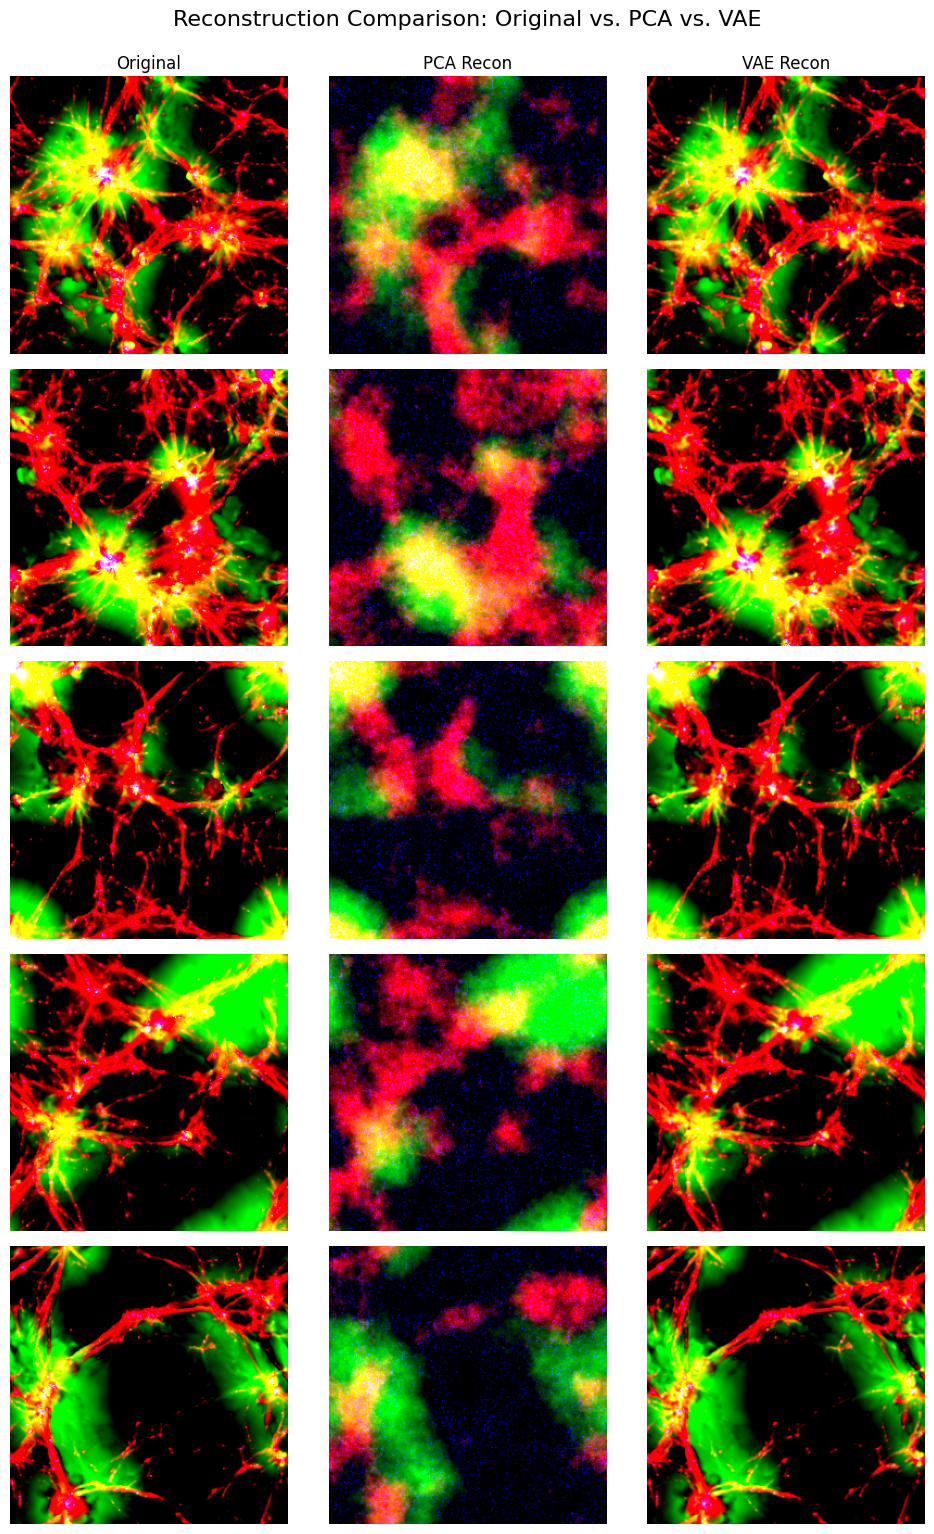

In [ ]:
# --- Reconstruction Visualizations ---
def plot_reconstructions(original, pca_recon, vae_recon, num_images=5, channels=CHANNELS):
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

 
    original_np = original.cpu().numpy() if torch.is_tensor(original) else original
    pca_recon_np = pca_recon.cpu().numpy() if torch.is_tensor(pca_recon) else pca_recon
    vae_recon_np = vae_recon.cpu().numpy() if torch.is_tensor(vae_recon) else vae_recon


    if channels == 1:
        original_np = original_np[:, 0, :,:] # Take first channel for grayscale plot
        pca_recon_np = pca_recon_np[:, 0, :, :]
        vae_recon_np = vae_recon_np[:, 0, :, :]
    else: # Transpose for matplotlib (C, H, W) -> (H, W, C)
        original_np = np.transpose(original_np, (0, 2, 3, 1))
        pca_recon_np = np.transpose(pca_recon_np, (0, 2, 3, 1))
        vae_recon_np = np.transpose(vae_recon_np, (0, 2, 3, 1))

    for i in range(num_images):
        idx = np.random.randint(0, len(original_np)) # Randomly pick an image

        # Original Image
        axes[i, 0].imshow(original_np[idx], cmap='viridis' if channels==1 else None)
        axes[i, 0].set_title("Original" if i == 0 else "")
        axes[i, 0].axis('off')

        # PCA Reconstruction
        axes[i, 1].imshow(pca_recon_np[idx], cmap='viridis' if channels==1 else None)
        axes[i, 1].set_title("PCA Recon" if i == 0 else "")
        axes[i, 1].axis('off')

        # VAE Reconstruction
        axes[i, 2].imshow(vae_recon_np[idx], cmap='viridis' if channels==1 else None)
        axes[i, 2].set_title("VAE Recon" if i == 0 else "")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.suptitle("Reconstruction Comparison: Original vs. PCA vs. VAE", y=1.02, fontsize=16)
    plt.show()

plot_reconstructions(X_test_np, pca_test_recon_img, vae_recon_test_img, num_images=5, channels=CHANNELS)

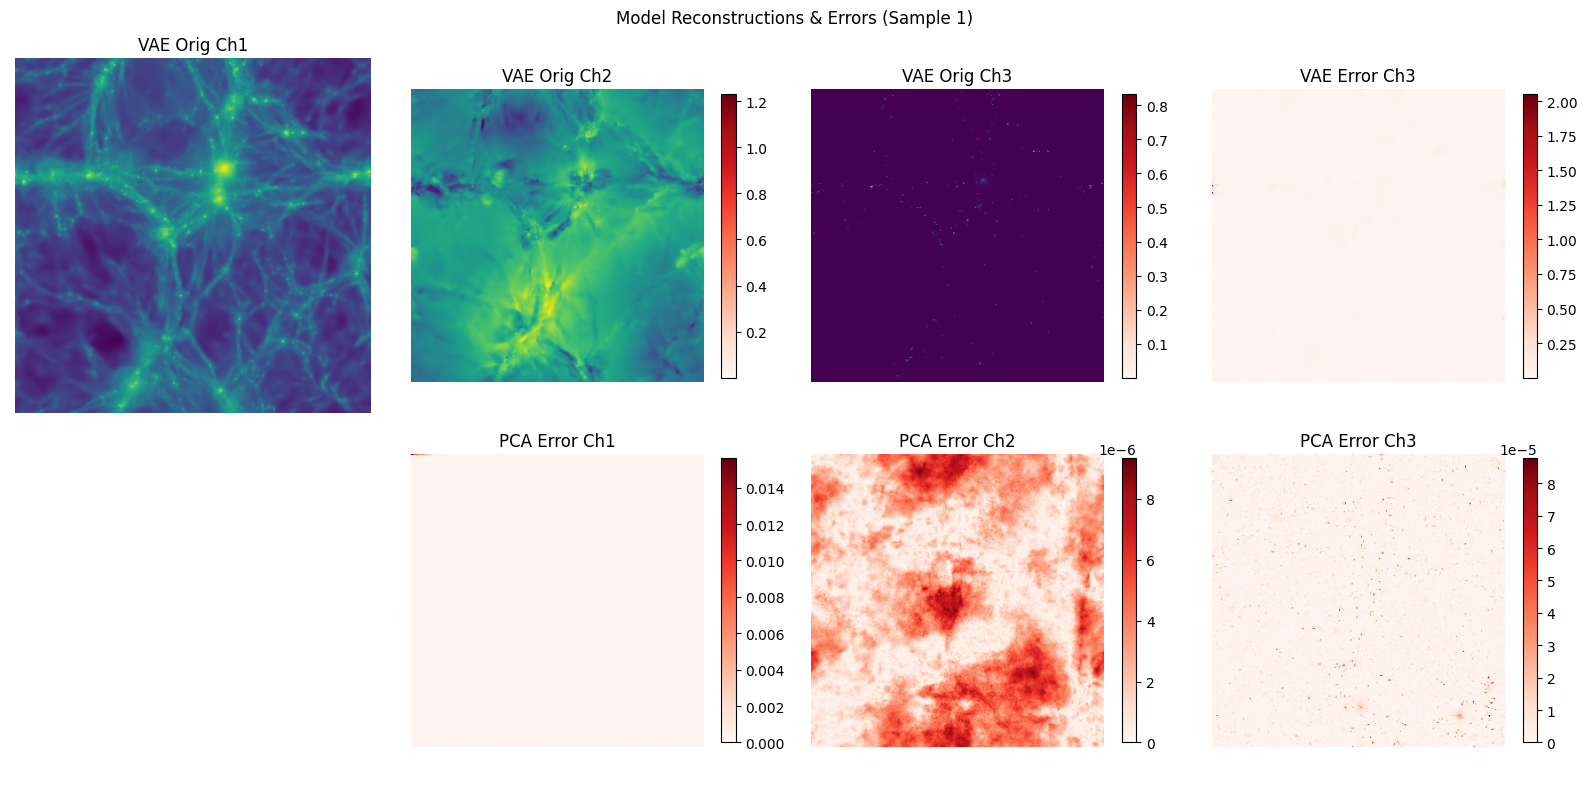

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi


metrics = {
    'VAE': {'MSE': 0.001453, 'SSIM': 0.987545, 'PSNR': 28.377865, 'KL': 0.63},
    'PCA': {'MSE': 0.495323, 'SSIM': 0.125638, 'PSNR': 3.051118,  'KL': 0.000}
}

models = list(metrics.keys())
metric_names = ['MSE', 'SSIM', 'PSNR', 'Silhouette', 'KL']
num_vars = len(metric_names)


norm_metrics = []
for m in models:
    vals = []
    for name in metric_names:
        val = metrics[m].get(name, 0)
        if name in ['MSE', 'KL']:
            norm = 1 / (1 + val)
        elif name in ['PSNR', 'SSIM', 'Silhouette']:
            norm = min(val / max(metrics[mn][name] for mn in models), 1.0)
        else:
            norm = val
        vals.append(norm)
    norm_metrics.append(vals)
norm_metrics = np.array(norm_metrics)

# -------------------------------------------------------------------
#  Raw Metrics Bar Chart
# -------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))
x = np.arange(len(models))
width = 0.15

for i, name in enumerate(metric_names):
    ax1.bar(x + i * width, [metrics[m][name] for m in models], width, label=name)

ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Metric Values', fontsize=12)
ax1.set_title('Raw Metrics Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9)
ax1.set_xticks(x + width * (num_vars - 1) / 2)
ax1.set_xticklabels(models)
ax1.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('raw_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
#  Normalized Radar Chart
# -------------------------------------------------------------------
angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
norm_metrics_appended = np.concatenate([norm_metrics, norm_metrics[:, [0]]], axis=1)

fig, ax2 = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for i, m in enumerate(models):
    ax2.plot(angles, norm_metrics_appended[i], 'o-', linewidth=2, label=m)
    ax2.fill(angles, norm_metrics_appended[i], alpha=0.25)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(metric_names, fontsize=11)
ax2.set_ylim(0, 1)
ax2.set_title('Normalized Metrics Radar', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.savefig('normalized_metrics_radar.png', dpi=300, bbox_inches='tight')
plt.show()


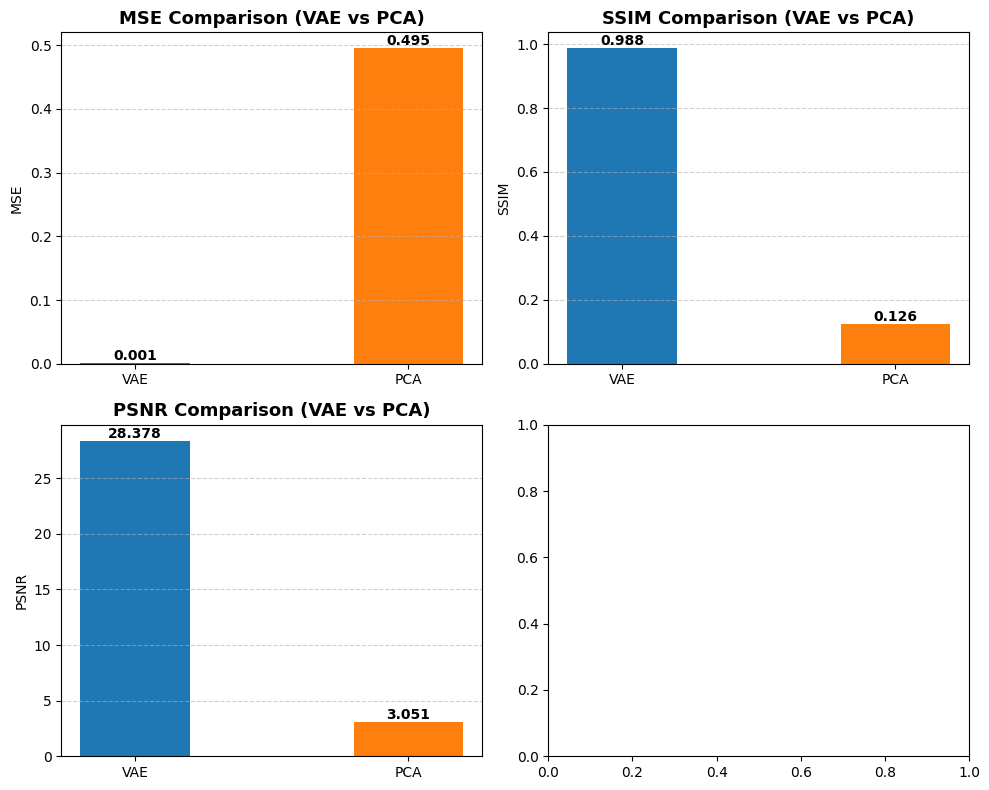

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


metrics = {
    'VAE': {'MSE': 0.001453, 'SSIM': 0.987545, 'PSNR': 28.377865},
    'PCA': {'MSE': 0.495323, 'SSIM': 0.125638, 'PSNR': 3.051118 }
}

models = list(metrics.keys())
metric_names = ['MSE', 'SSIM', 'PSNR', ]

# --- Define colors for consistency ---
colors = {
    'VAE': '#1f77b4',  # blue
    'PCA': '#ff7f0e'   # orange
}

# --- Plot 4 separate bar charts ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # flatten 2x2 array into a list for easy looping

for i, metric in enumerate(metric_names):
    values = [metrics[m][metric] for m in models]
    bars = axes[i].bar(models, values, color=[colors[m] for m in models], width=0.4)
    
    # Annotate values on top of bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customize chart appearance
    axes[i].set_title(f"{metric} Comparison (VAE vs PCA)", fontsize=13, fontweight='bold')
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    
plt.tight_layout()
plt.savefig('vae_pca_metric_comparisons.png', dpi=300, bbox_inches='tight')
plt.show()


In [59]:
# Create a new log file
with open("training_log.txt", "w") as f:
    f.write("""PASTE YOUR FULL TRAINING OUTPUT HERE""")


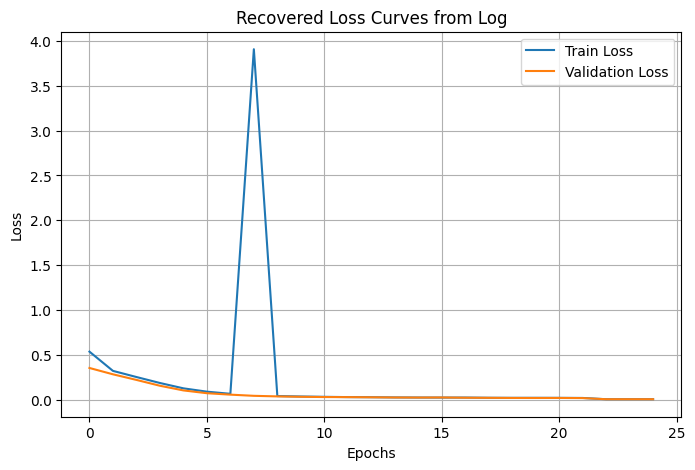

In [61]:
import re

train_losses, val_losses = [], []
with open("training_log.txt", "r") as f:
    for line in f:
        match = re.search(r"Train Loss:\s*([\d.]+)\s*\|\s*Val Loss:\s*([\d.]+)", line)
        if match:
            train_losses.append(float(match.group(1)))
            val_losses.append(float(match.group(2)))

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Recovered Loss Curves from Log')
plt.legend()
plt.grid(True)
plt.show()
